In [1]:
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
from math import e
import statistics as st
import cmath
import scipy
import scipy.stats as ss
import random
import seaborn as sns
import pandas as pd
import pyswarms
import emcee
import corner

In [2]:
data = map(lambda x: [ x[0], x[1], x[2] ],
        np.loadtxt("/Users/gopipatel/Documents/RRI_VSP/saras3_S11_200mm_above_water.s1p", skiprows=5))
d=list(data) #List of the format [Frequency, Magnitude, Phase (in degrees)]

In [3]:
c=3*10**8  # speed of light (m/s)
freq=[d[i][0] for i in range(len(d))] #frequency

In [4]:
def Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f, l): 
    A=0
    B=0
    C=0
    l=l
    itr=3
    Tmeas=[]
    phi_A=0
    phi_N=0
    phi_f=0
    P_ref=300
    
    l=l
    freq= [d[i][0] for i in range(len(d))]
    for i in range(len(freq)):
        
        phi= (4*math.pi*(freq[i])*l)/(0.7*c)
        A=sum((abs(gamma_A)**k)*(abs(gamma_N)**k)*sum(math.cos((2*l-k)*(phi_N+phi_A+phi))for l in range(k+1)) for k in range(itr))   
        
        B=sum(2*abs(f)*(abs(gamma_A)**(o+1))*(abs(gamma_N)**o)*math.cos(phi_f+(o+1)*(phi_A+phi)+o*phi_N) for o in range(itr))
    
        C=sum((abs(gamma_A)**b)*(abs(gamma_N)**b)*sum(math.cos((2*c-b)*(phi_N+phi_A+phi)) for c in range(b+1)) for b in range(itr))
        
        Tmeas.append((PA*A-P_ref)+PN*(B+(abs(f)**2)*(abs(gamma_A)**2)*C))
    return(Tmeas)

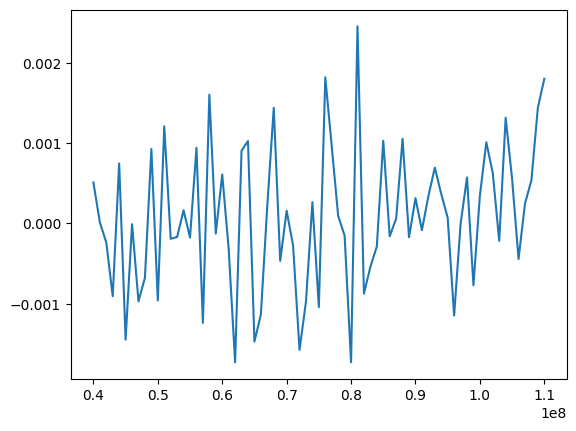

In [5]:
#Parameters
'''
PA  -------> Power at the Antenna terminal, can be open, short, load, and sky
PN  -------> Noise Power of the LNA in K 
P_ref  ----> Noise power from reference, considered to be ambient temperature
f ---------> Corr factor between the fwd and bkwd of the LNA, complex qty
gamma_A ---> Reflection Coeff. at the open terminal in db - Open
gamma_N ---> Reflection Coeff. at the LNA i/p (gamma N):10db
phi_A  ----> Phase of the wave reflected at the open terminal
phi_N  ----> phase of the noise wave
phi_f  ----> phase of the corr factor
'''

#simulated Tmeas

ip_params=[300,0,70,0.3,0.1,1]  #PA, gamma_A, PN, gamma_N, f, l
TA_exp=Compute_Tmeas_(*ip_params)+np.random.normal(0,0.001,len(freq)) #adding Gaussian Noise
plt.plot(freq,TA_exp)

In [6]:
def chi_squared(params):
    T_model = Compute_Tmeas_(*params)+np.random.normal(0,0.001,len(freq)) #adding Gaussian Noise #Observed
    s=0.001                            #uncertainity
    chi2 = np.sum([((TA_exp[:] - T_model[:])/s)** 2 ])
    #chi2 = np.sum([((TA_exp[i] - T_model[i])/s)** 2  for i in range(len(freq))]) #least square fitting
    return chi2


In [7]:
#Basin Hoping

sig_ss=0.001
#args = (x1,y1,e1,sig_ss,pd['domain'], pd['additive'], pd['joint'], do_opt, met)
OPTIONS={'ftol':1e-6, 'xtol': 1e-6, 'maxiter':1e5, 'maxfev':1e5}

random.seed(15)
PA=random.randrange(0,350)
gamma_A=random.uniform(0,1)
PN=random.randrange(50,150)
gamma_N=random.uniform(0,1)
f=random.uniform(0.05,0.5)
l=random.uniform(0.05,3)
x0=[PA,gamma_A,PN,gamma_N,f,l] #initial value
bounds=((0,350),(0,1),(50,150),(0,1),(0.05,0.5),(0.05,3)) #to return acceptable range for the params: PN, gamma_N, f, l
#minimizer_kwargs = {"method":"Nelder-Mead", 'options':OPTIONS, "bounds": bounds}

#result=scipy.optimize.basinhopping(chi_squared, x0, niter=200, T=1, stepsize=0.05, minimizer_kwargs=minimizer_kwargs)

p00 = x0

minimizer_kwargs={"method":"Nelder-Mead", 'options':OPTIONS, "bounds": bounds}

#for i in range(3):

   #print("\nPolynomial Order : {}".format(i+1))

for i in range (50):
    print(i+1)
    pout = scipy.optimize.basinhopping(chi_squared, p00, minimizer_kwargs=minimizer_kwargs,T=1e-5, stepsize=1e-5, niter=2, seed=10)
    p00 = pout.x
print(p00)

1


/Users/gopipatel/my_env/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:292: OptimizeWarning: Unknown solver options: ftol, xtol
  return self.minimizer(self.func, x0, **self.kwargs)
/Users/gopipatel/my_env/lib/python3.10/site-packages/scipy/optimize/_basinhopping.py:292: OptimizeWarning: Initial guess is not within the specified bounds
  return self.minimizer(self.func, x0, **self.kwargs)


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
[3.00000054e+02 0.00000000e+00 1.22684311e+02 8.12676379e-02
 1.73291209e-01 2.99999882e+00]


In [8]:
def evolve_MCMC(ip_params, type,nsteps, initial_value):# Define parameter names
    parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
    inp_params=ip_params
    # Define bounds for parameters
    min_values = [0.0, 0.0, 50.0, 0.0, 0.05,0.05]
    if type=='open' or type=='short':
        max_values= [5, 1, 150, 1, 0.5, 5] 
    else:
        max_values = [500, 1, 150, 1, 0.5, 5] #maximum value of mass being scanned for load terminal
    
    
    # Define the Expected TA values
    TA_exp = Compute_Tmeas_(*inp_params) + np.random.normal(0,0.001,len(freq))  # Expected TA values
    TA_exp=np.array(TA_exp)
    
    ########## Define the log-likelihood function
    def log_likelihood(params):
        PA, gamma_A, PN, gamma_N, f, l = params
    
        # Compute model TA
        TA_model = Compute_Tmeas_(PA, gamma_A, PN, gamma_N, f,  l) + np.random.normal(0,0.001,len(freq))
        TA_model=np.array(TA_model)

        # Compute chi-squared with weights
        s = 0.001  # Uncertainty
        chi2 = np.sum([((TA_exp - TA_model)/s)** 2 ]) 
    
        return -0.5*chi2 - np.log(math.sqrt(2*np.pi)*s) # Likelihood function
    
    ########## Define the log-prior function
    def log_prior(params):
        
        PA, gamma_A, PN, gamma_N, f, l = params
        """
        # Check if params are within bounds
        if 0.0 < PA < 5 and 0.0 < gamma_A < 1.0 and 5.0 < PN < 100.0 and 0.0 < gamma_N < 1.0 and 0.05 < f < 0.9 and 0.1 < l < 1.0:
            return 0.0
        return -np.inf
        """
    
        
        for p, min_v, max_v in zip(params, min_values, max_values):
            if not (min_v <= p <= max_v):
                return -np.inf  # Reject sample
        return 0.0  # Uniform prior
        
    
    ######### Define the full log-probability function
    
    def log_probability(params):
        lp = log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(params)
    
    # Number of walkers and steps
    ndim = 6  # Number of parameters
    nwalkers = 150  # Number of MCMC walkers
    nsteps = nsteps  # Number of MCMC steps per walker
    
    ############### Initialize walkers around a random point in parameter space
    
    #initial = np.array([np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)])
    
    #initial = np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)])
    initial_value=initial_value
    
    ########## Starting positions for the walkers
    #pos = initial 
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(pm,(1+1e-1)*pm) for pm in inp_params] for _ in range(nwalkers)])
    pos= initial_value + 1e-1*np.random.randn(nwalkers, ndim) #initial_exact[None,:]*
    #ind_pos = pos<0
    #pos[ind_pos] = np.abs(1e-1*np.random.randn(nwalkers, ndim))

    for idim in range(ndim):
        ind_pos = pos[:,idim]<0
        pos[ind_pos,idim] = np.abs(pos[ind_pos,idim])
    
    #pos= initial_exact+ 1e-1*np.array([[np.random.uniform(min_v, max_v) for min_v, max_v in zip(min_values, max_values)] for _ in range(nwalkers)]) 
    
    ############ Set up the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, threads=10)
    
    ############ Run MCMC
    print("Running MCMC...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    ############ Extract the samples
    #samples = sampler.flatchain
    full_samples=sampler.get_chain()
    samples = sampler.get_chain(discard=0, thin=10, flat=True)

    ######### Compute log-likelihoods for all samples
    log_likes = np.array([log_likelihood(p) for p in samples])
    
    ######### Find the index of the maximum likelihood
    max_likelihood_index = np.argmax(log_likes)
    
    ########## Get the best-fit parameters
    best_fit_params = samples[max_likelihood_index].tolist()

    return full_samples,samples,best_fit_params

In [10]:
#evolve MCMC
ip_params=[300,0,70,0.3,0.1,1]
#initials=result.x #input parameters
initials=p00#[0.0008,1.0,70.07,0.2990,0.0998,0.999]
chains=3
nsteps=3000

full_samples, samples, best_fit_params= evolve_MCMC(ip_params,type='load',nsteps=nsteps, initial_value=initials)

Running MCMC...


100%|███████████████████████████████████████| 3000/3000 [04:32<00:00, 10.99it/s]


2025-03-25 16:39:23,149 - root - WARNING - Too few points to create valid contours
2025-03-25 16:39:23,235 - root - WARNING - Too few points to create valid contours
2025-03-25 16:39:23,276 - root - WARNING - Too few points to create valid contours
2025-03-25 16:39:23,335 - root - WARNING - Too few points to create valid contours
2025-03-25 16:39:23,370 - root - WARNING - Too few points to create valid contours


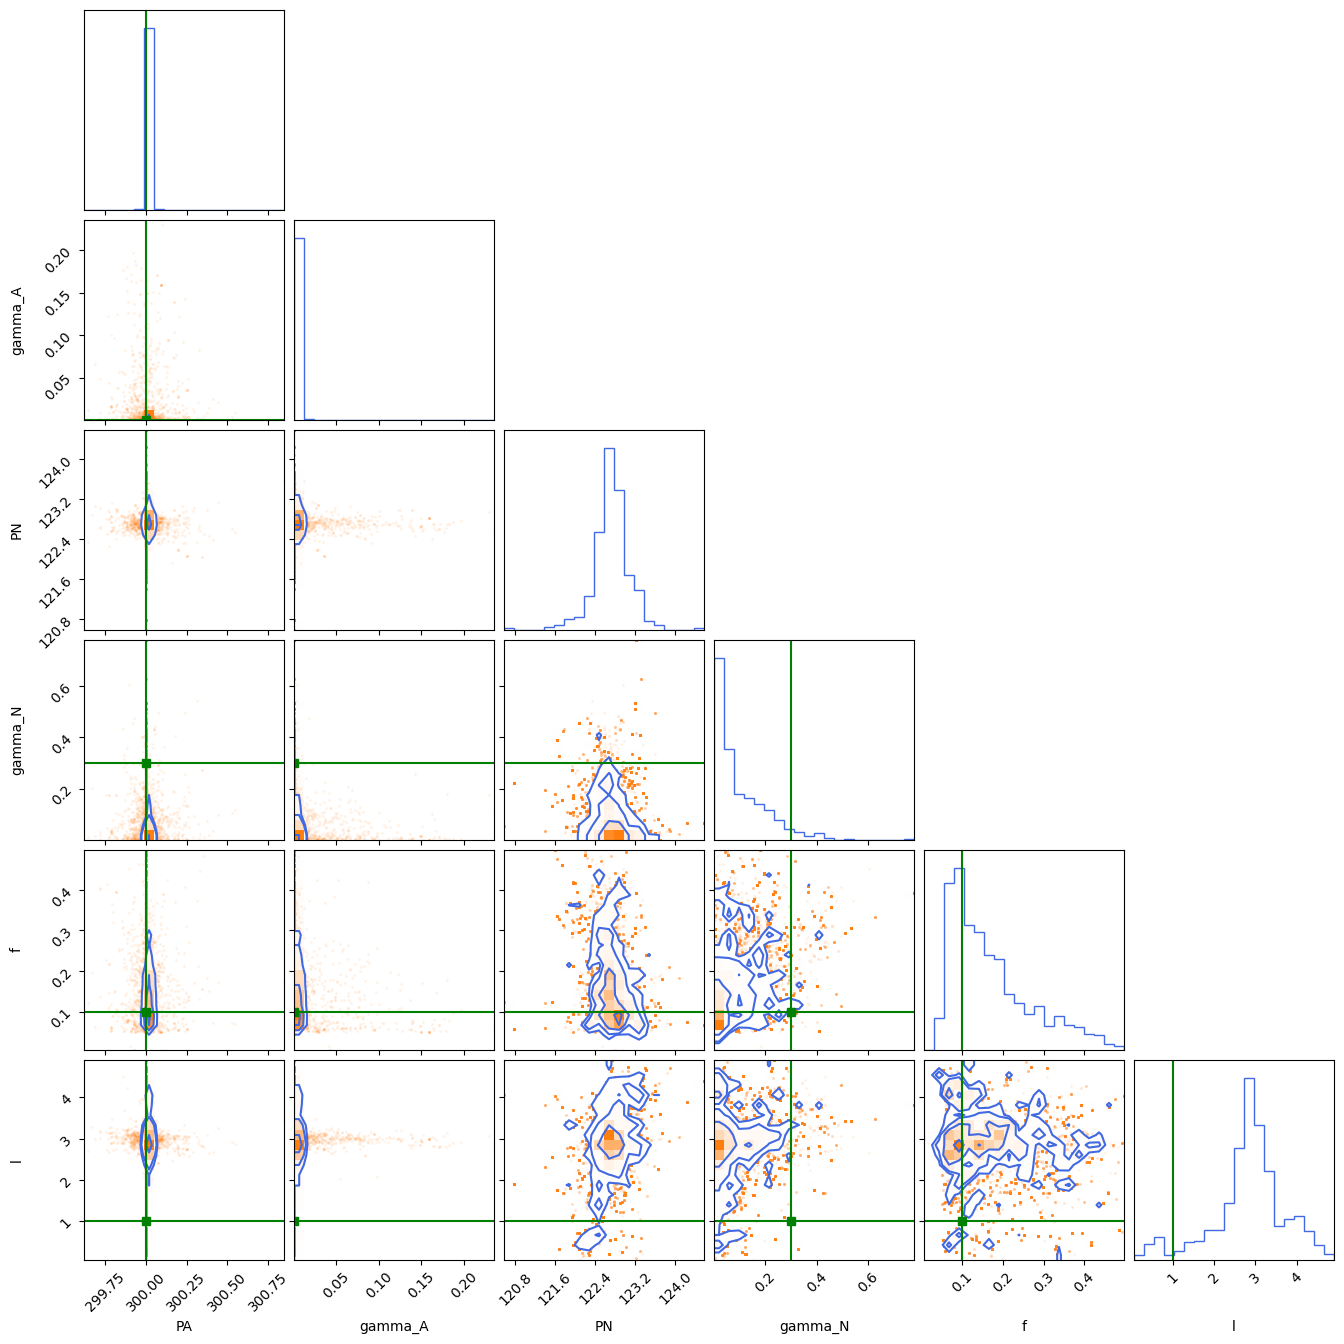

Best-fit parameters (Maximum Likelihood Estimate): [299.99983609081147, 1.2238551654414288e-06, 122.41243176195555, 0.08650029345741302, 0.26162355685923677, 2.93119682640097]


In [11]:

#chi2 limit and initial exct+random
parameter_names = ["PA", "gamma_A", "PN", "gamma_N", "f","l"]
#corner plot 
fig = corner.corner(samples, labels=parameter_names, truths=ip_params, color='C1',  # Change color of the contour and histograms
hist_kwargs={"color": "royalblue"},  # Set histogram color
contour_kwargs={"colors": ["royalblue"]},  # Set contour color
truth_color="green" ) # Color for the true parameter values)
plt.show()

#print("Expected Paramerters:",ip_params)
print("Best-fit parameters (Maximum Likelihood Estimate):", best_fit_params)